# Import and utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm import tqdm

In [2]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output
import jax 
from functools import partial

class VideoWriter:
    def __init__(self, filename, fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)
    
    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
              img = np.uint8(img.clip(0, 1)*255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)
    
    def close(self):
        if self.writer:
            self.writer.close()
    
    def __enter__(self):
        return self
    
    def __exit__(self, *kw):
        self.close()
    
    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        display(mvp.ipython_display(fn, **kw))
            
def glyph(p):
    return (1.0-(p*p).sum(-1)).clip(0.0)

@partial(jax.jit, static_argnames=['view_size', 'R', 'extent'])
def render(pos, color=jnp.ones(3), extent=16.0, view_size=(512, 512), R=0.4):
    w, h = view_size
    pos = pos*w/extent + jnp.float32([w, h])/2
    r_px = R*w/extent
    p = pos.T[..., None, None]
    xy = jnp.mgrid[-r_px:r_px, -r_px:r_px]
    xy = jnp.round(p) + xy[:, None]
    v = glyph((xy-p).transpose([1, 2, 3, 0])/r_px)[...,None]
    x, y = jnp.int32(xy)
    inside = (x >= 0) & (y >= 0) & (x < w) & (y < h)
    v = v*color[...,None,None,:]
    return 1.0-jnp.zeros([h, w, color.shape[-1]]).at[y, x].add(v*inside[...,None], mode='drop')[::-1]

# Load run

In [3]:
from analysis.genomes import compute_genome_data
from analysis.species import compute_species_data
from analysis.loading import load_run_data

In [8]:
pth = "multispecies/02_15_2024_04_56_11_1"

In [9]:
raw_data = load_run_data(pth, seed=1, return_config=False)

100%|███████████████████████████████████████████████████████████████████████▉| 4999/5000 [00:39<00:00, 127.71it/s]


In [10]:
gdata = compute_genome_data(raw_data)

Computing unique genomes set
Found 221383 unique genomes
Computing pca projection
		explained variance:  [0.20192449 0.15581777 0.0855704  0.0611507  0.05601113]


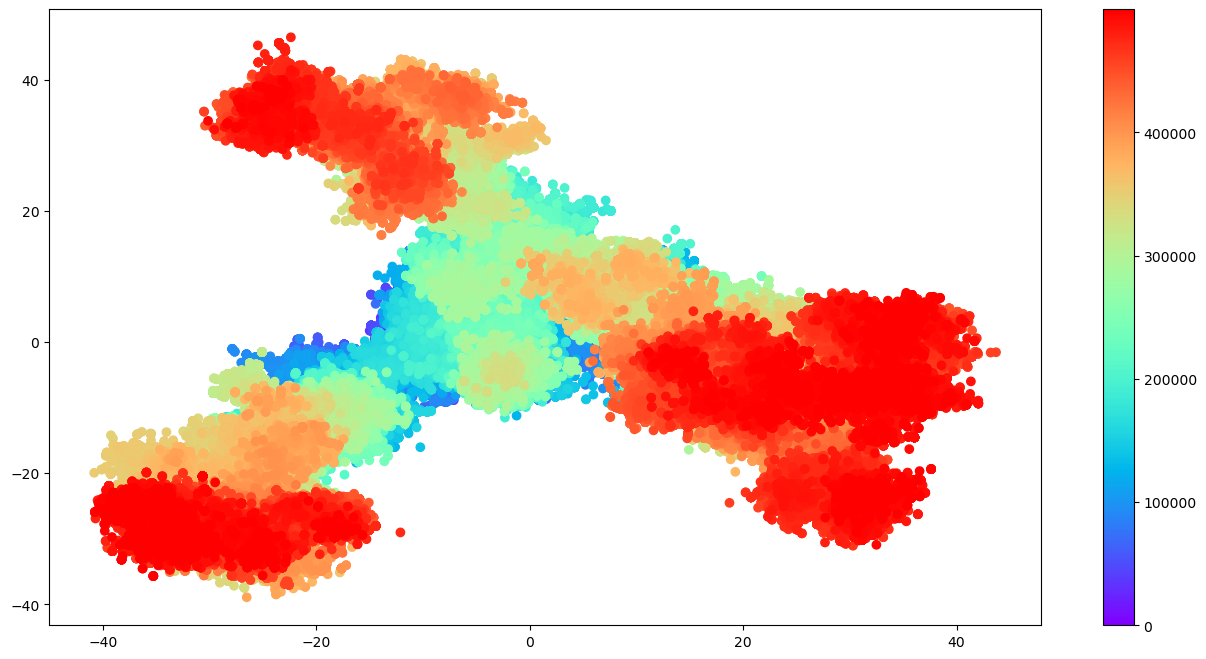

In [11]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
pts = np.concatenate(gdata.uPt_pr)[:,:2]
plt.scatter(*pts.T, cmap="rainbow", c=gdata.fT)
plt.colorbar()
plt.show()

In [12]:
pts = [upr[:,:2] for upr in gdata.uPt_pr]
fpts = np.concatenate(pts)
mu = fpts.mean(0, keepdims=True)
std = fpts.std()
pts = [(p - mu)/std for p in pts]

In [13]:
max_a = max([a.max() for a in gdata.aPt])

In [14]:
with VideoWriter("../test.mp4", 180) as vid:
    for _pts, uP in zip(pts, gdata.uPt):
        c = uP[:, :3]
        im = render(_pts*2.5, R=0.2, color=c)
        vid.add(im)
    vid.show(height=512, width=512)

In [15]:
minp, maxp = gdata.uP.min(), gdata.uP.max()
def get_diversity(scale):
    bins = np.linspace(minp, maxp, scale)
    bin_uPt = [np.digitize(upt, bins) for upt in gdata.uPt_pr]
    diversities = [len(np.unique(bupt))/(scale**bin_uPt[0].shape[-1]) for bupt in bin_uPt]
    return diversities, bin_uPt

In [16]:
diversities = []
bin_uPt = []
scales = (10, 20, 30, 40, 50, 100)
for scale in tqdm(scales):
    div, bin_upt = get_diversity(scale)
    bin_uPt.append(bin_upt)
    diversities.append(div)

100%|███████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.91it/s]


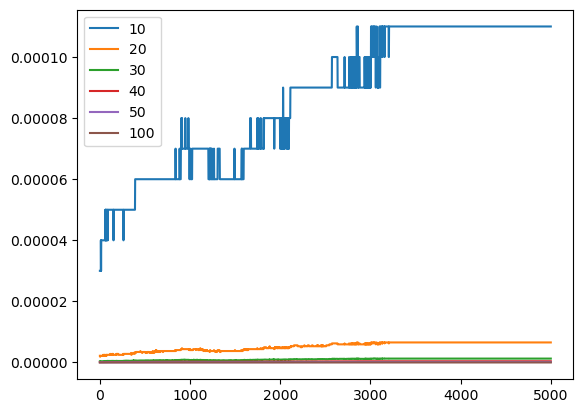

In [19]:
for div, sc in zip(diversities, scales):
    plt.plot(div, label=sc)
plt.legend()
#plt.yscale("log")
plt.show()

In [191]:
ms = []
isc = 2
sc = scales[isc]
bupt = bin_uPt[isc]
bupt = [bp[:, :2] for bp in bupt]
bins = np.linspace(minp, maxp, sc)
for ids in tqdm(bupt):
    x = np.zeros((sc+1,sc+1))
    x[*ids.T] = 1.
    ms.append(x)

100%|██████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 55690.45it/s]


In [192]:
ms[0].shape

(31, 31)

In [193]:
with VideoWriter("../test_grid.mp4", 120) as vid:
    for m in ms:
        im = np.dstack([m]*3)
        vid.add(im)
    vid.show(height=512, width=512)

python(82192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(82193) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [194]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def display_ms(ms):
    ims = []
    fig, ax = plt.subplots()
    for m in ms:
        im = m
        im = ax.imshow(im, animated=True)
        ims.append([im])
    anim = animation.ArtistAnimation(fig, ims, interval=10, blit=True,
                                    repeat_delay=1000)
    vid = anim.to_html5_video()
    html = HTML(vid)
    return html

python(82211) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


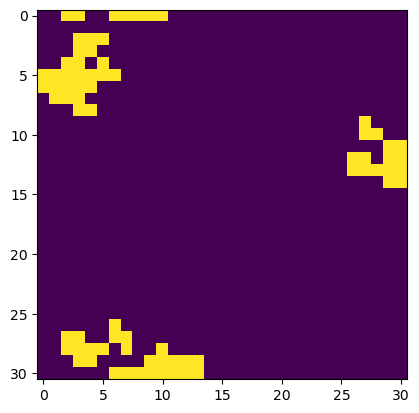

In [195]:
html = display_ms(ms[:])
display(html)

In [33]:
from typing import NamedTuple

In [52]:
class SpatialData(NamedTuple):
	comPt: list
	bbminPt: list
	bbmaxPt: list
	oPPt: list
    
@jax.jit
def overlap(bbmin1, bbmax1, bbmin2, bbmax2):
	bbmin = jnp.maximum(bbmin1, bbmin2)
	bbmax = jnp.minimum(bbmax1, bbmax2)
	return jnp.prod(bbmax-bbmin)

def compute_spatial_data(data):

	uPit = data.uPit
	iPt = data.iPt

	Xsq = iPt[0].shape[0]
	X = int(np.sqrt(Xsq))
	L = np.mgrid[:X, :X].transpose((1,2,0)).reshape((Xsq, 2))

	bbmins = []
	bbmaxs = []
	coms = []
	ovrlps = []
	for upit, ipt in tqdm(zip(uPit, iPt)):
		n = upit.shape[0]
		com = jax.ops.segment_sum(L, ipt, num_segments=n)
		coms.append(com)
		bbmin = jax.ops.segment_min(L, ipt, num_segments=n)
		bbmins.append(bbmin)
		bbmax = jax.ops.segment_max(L, ipt, num_segments=n)
		bbmaxs.append(bbmax)
		ovrlp = jax.vmap(
			jax.vmap(overlap, in_axes=(None,None,1,1)), in_axes=(0,0, None, None)
		)(bbmin[:, None], bbmax[:, None], bbmin[None], bbmax[None])
		ovrlps.append(ovrlp)


	return SpatialData(comPt=coms, bbminPt=bbmins, bbmaxPt=bbmaxs, 
		               oPPt=ovrlps)

In [53]:
spatial_data = compute_spatial_data(gdata)

5000it [00:29, 167.08it/s]


In [57]:
avg_ovrlp = [ovrlp.min() for ovrlp in spatial_data.oPPt]

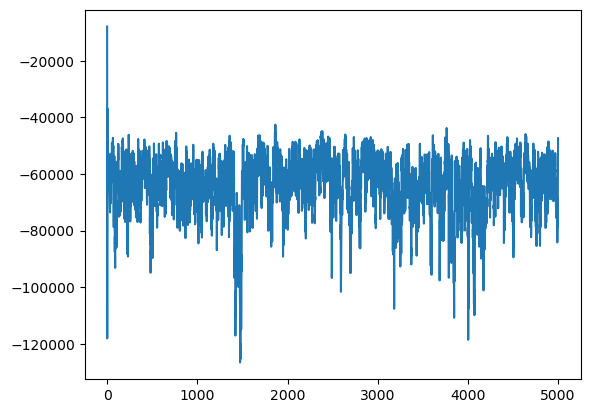

In [58]:
plt.plot(avg_ovrlp)

In [59]:
bbmi = spatial_data.bbminPt
bbma = spatial_data.bbmaxPt

In [68]:
for bbi, bba in zip(bbmi, bbma):
    assert np.all(bbi<=bba), f"{bbi}, {bba}"

In [67]:
bbi > bba

Array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [Fal